# Classification. Linear models and KNN

In [711]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [712]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [713]:
from sklearn.exceptions import NotFittedError

In [953]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        st = X @ weights
        return 1/(1 + np.exp(-st))
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        X_ext = np.hstack([np.ones((x.shape[0], 1)), x]) # a constant feature is included to handle intercept
        st = (X_ext @ weights)
        exp = np.exp(-st * y)  
        summa = np.sum(np.log(1 + exp))
        return (1/y.shape[0]) * summa + np.linalg.norm(weights, 2)/(2*self.C)
                
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
          
        for i in range(self.max_iter):
            st = (X_ext @ self.weights_)
            exp = np.exp(-st * y)
            delta = -(1/y.shape[0]) * np.sum(y * X_ext.transpose() * (1 - 1/(1 + exp)), axis=1) + self.weights_/self.C
            self.weights_ -= self.eta * delta
            if np.linalg.norm(self.eta * delta, 2) < self.tol:
                break 

    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        pr = self.predict_proba(X)
        pr[pr > 0.5] = 1
        pr[pr <= 0.5] = -1
        return pr

In [954]:
from sklearn import datasets
from sklearn import metrics

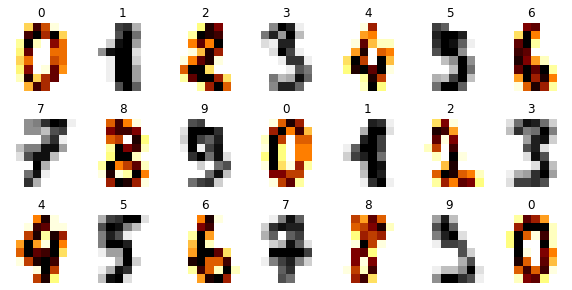

In [955]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [956]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [957]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [963]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [965]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [966]:
lr_clf.fit(X_train, y_train)

In [967]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [889]:
model = CustomLogisticRegression()

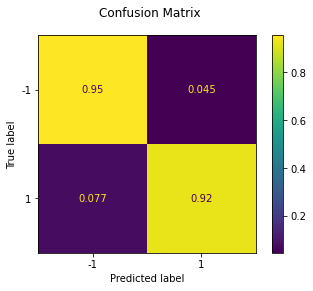

In [890]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [892]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [893]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

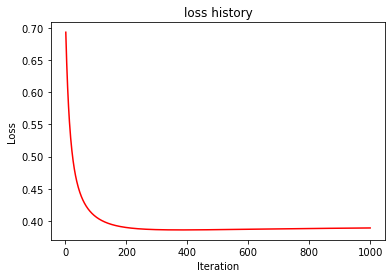

In [992]:
N = 1000
def generate():
    for i in range(N):
        lr_clf = CustomLogisticRegression(max_iter=i, zero_init=True)
        lr_clf.fit(X_train, y_train)
        loss = lr_clf.get_loss(X_train, lr_clf.weights_, y_train)
        yield loss 
loss = np.fromiter(generate(), dtype=float, count=-1)

i = np.linspace(1, N, N, endpoint=True)

plt.title("loss history")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.plot(i, loss, color ="red")
plt.show()

In [ ]:
# Видим, что с увеличением итераций уменьшается значение лосс функции.

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

In [993]:
Eta = 0.0001
N = 1000
def generate():
    for i in range(N):
        lr_clf = CustomLogisticRegression(max_iter=i, eta = Eta, zero_init=True)
        lr_clf.fit(X_train, y_train)
        loss = lr_clf.get_loss(X_train, lr_clf.weights_, y_train)
        yield loss 
loss_eta_0_0001 = np.fromiter(generate(), dtype=float, count=-1)

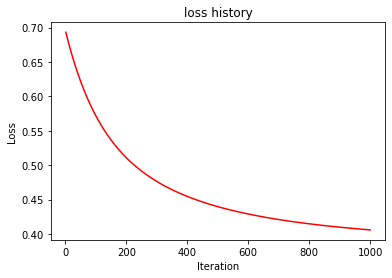

In [996]:
plt.title("loss history")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.plot(i, loss_eta_0_0001, color ="red")
plt.show()

In [994]:
Eta = 0.01
N = 1000
def generate():
    for i in range(N):
        lr_clf = CustomLogisticRegression(max_iter=i, eta = Eta, zero_init=True)
        lr_clf.fit(X_train, y_train)
        loss = lr_clf.get_loss(X_train, lr_clf.weights_, y_train)
        yield loss 
loss_eta_0_01 = np.fromiter(generate(), dtype=float, count=-1)

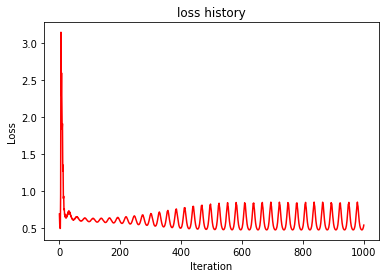

In [997]:
plt.title("loss history")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.plot(i, loss_eta_0_01, color ="red")
plt.show()

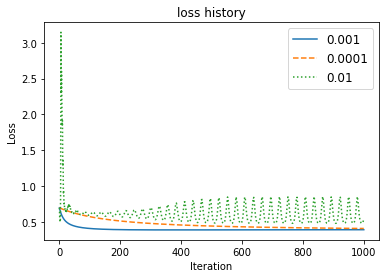

In [1014]:
plt.title("loss history")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.plot(i, loss, '-', label='0.001');
plt.plot(i, loss_eta_0_0001, '--', label='0.0001');
plt.plot(i, loss_eta_0_01, ':', label='0.01');
plt.legend(loc='best', fontsize=12)
plt.show()

#### В предыдущем задании мы построили график по eta по умолчанию (0.001), теперь мы построили с eta = 0.0001. Видим, что график стал сходить к 0 гораздо медленнее. Затем, построили график с eta = 0.01 и видим, что график ещё быстрее сходится к 0, чем график из прошлого задания, но потом резко поднимается.
#### Вывод: чем больше learning rate, тем быстрее loss фукнция стремиться к своему минимуму. Но это не значит, что чем больше learning rate, тем лучше.

**(0.5 points)** Try different regularization parameter values and compare the model quality.

In [999]:
C_my=5.0
N = 1000
def generate():
    for i in range(N):
        lr_clf = CustomLogisticRegression(max_iter=i, C=C_my, zero_init=True)
        lr_clf.fit(X_train, y_train)
        loss = lr_clf.get_loss(X_train, lr_clf.weights_, y_train)
        yield loss 
loss_С_5 = np.fromiter(generate(), dtype=float, count=-1)

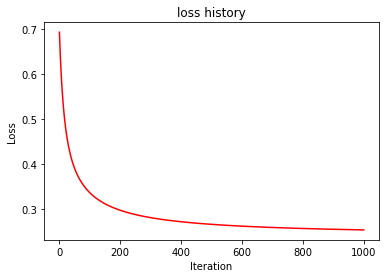

In [1004]:
plt.title("loss history")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.plot(i, loss_С_5, color ="red")
plt.show()

In [1001]:
C_my=0.5
N = 1000
def generate():
    for i in range(N):
        lr_clf = CustomLogisticRegression(max_iter=i, C=C_my, zero_init=True)
        lr_clf.fit(X_train, y_train)
        loss = lr_clf.get_loss(X_train, lr_clf.weights_, y_train)
        yield loss 
loss_С_0_5 = np.fromiter(generate(), dtype=float, count=-1)

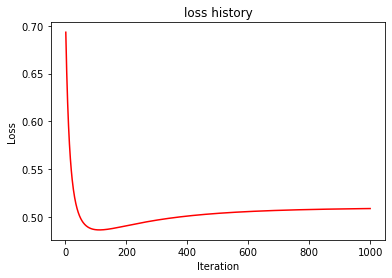

In [1002]:
plt.title("loss history")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.plot(i, loss_С_0_5, color ="red")
plt.show()

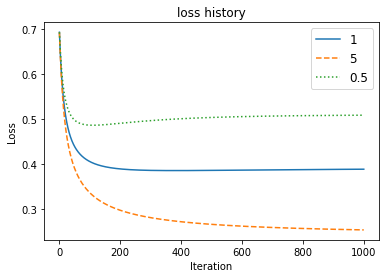

In [1012]:
plt.title("loss history")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.plot(i, loss, '-', label='1');
plt.plot(i, loss_С_5, '--', label='5');
plt.plot(i, loss_С_0_5, ':', label='0.5');
plt.legend(loc='best', fontsize=12)
plt.show()

#### Вспомним самый первый график лосс функции со значением по умолчанию C=1.0 и сравним с построенным здесь C=5.0 и C=0.5. Видно, что график с C=5.0 быстрее и лучше уменьшается, чем с C=1.0. А график с C=0.5 уменьшается медленнее, чем с C=1.0. Получается, что C лучше брать побольше.

**(0.5 points)** Compare zero initialization and random initialization. 

In [1015]:
N = 1000
def generate():
    for i in range(N):
        lr_clf = CustomLogisticRegression(max_iter=i, zero_init=False)
        lr_clf.fit(X_train, y_train)
        loss = lr_clf.get_loss(X_train, lr_clf.weights_, y_train)
        yield loss 
loss_random = np.fromiter(generate(), dtype=float, count=-1)

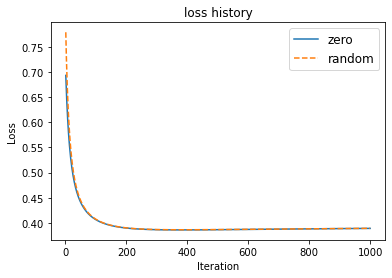

In [1016]:
plt.title("loss history")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.plot(i, loss, '-', label='zero');
plt.plot(i, loss_random, '--', label='random');
plt.legend(loc='best', fontsize=12)
plt.show()

#### Вспомним самый первый график лосс функции со значением по умолчанию zero_init=True и сравним с построенным здесь zero_init=False. По графику отличий незаметно. Разве что нулевые начали лучше, чем рандомные. Но тут думаю как повезёт, а в целом не видно существенных отличий.

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [1560]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        #num_x = X.shape[0]
        #num_y = Y.shape[0]
        #dists = np.zeros((num_x, num_y))
        #for i in range(num_x):
        #    for j in range(num_y):
        #        dists[i, j] = np.sqrt(np.sum((X[i] - Y[j])**2))
        #return dists       
        P = np.add.outer(np.sum(X**2, axis=1), np.sum(Y**2, axis=1))
        N = np.dot(X, Y.T)
        return np.sqrt(P - 2*N)
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        df = pd.DataFrame({'class': y, 'weights': weights})
        df = df.groupby(['class'])['weights'].agg(['sum']).reset_index()
        cl = pd.DataFrame({'class': self.classes_})
        cl['index'] = cl.index
        m = df.merge(cl, how='inner',  left_on='class', right_on='class')
        return m.sort_values(by=['index'], ascending=True)['sum']
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            
            weights_of_points = np.ones(P.shape)
            if self.weights == 'distance':
                weights_of_points = 'your code'
                
            # <your code>
            pass
        
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        # <your code>
        pass

In [1561]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [1562]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [1563]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

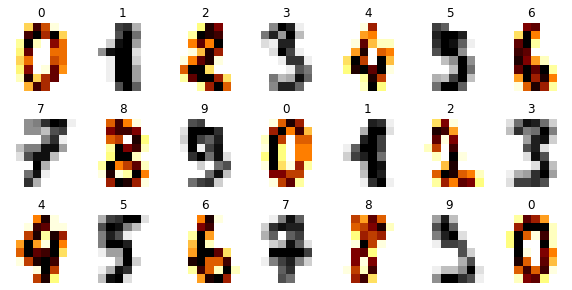

In [1564]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [1300]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [1301]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [ ]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

< your thoughts >

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

In [ ]:
## your code

< your thoughts >

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

In [ ]:
## your code

< your thoughts >

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

< your thoughts >

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

< your thoughts >

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [687]:
PATH = "./data/"

In [688]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [689]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

,Sex,count
0,female,43886
1,male,56114


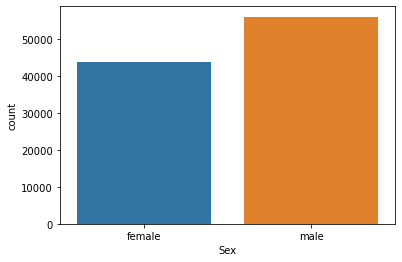

In [690]:
## your code
# Сколько женщин и сколько мужчин было на борту
sex = data.groupby(['Sex'])['Sex'].agg(['count']).reset_index()
sns.barplot(x=sex['Sex'], y=sex['count']);
sex

,Survived,N_count
0,not survived,57226
1,survived,42774


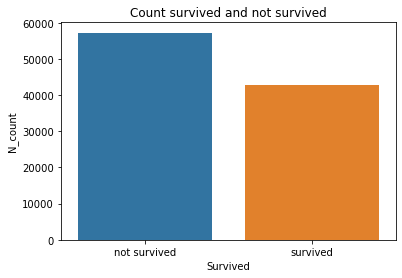

In [691]:
#Сколько выжило и не выжило
plt.title("Count survived and not survived")
survived_or_not = data.groupby(['Survived'])['Survived'].agg(['count']).reset_index()
survived_or_not['Survived'] = survived_or_not['Survived'].map({1: 'survived', 0: 'not survived'})
survived_or_not = survived_or_not.rename(columns={'count':'N_count'})
sns.barplot(x=survived_or_not['Survived'], y=survived_or_not['N_count']);
survived_or_not

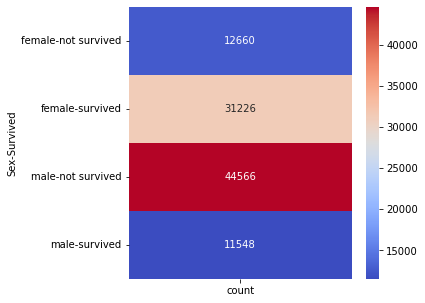

In [692]:
#Cколько женщин и мужчин выжило и не выжило
plt.figure(figsize=(5,5))
data['PassengerId'] = data.index
data_slice_Sex_Survived_OrNot_count = data.groupby(['Sex', 'Survived'])['PassengerId'].agg(['count']).reset_index()
data_slice_Sex_Survived_OrNot_count = data_slice_Sex_Survived_OrNot_count.replace(to_replace = 0, value = "not survived")
data_slice_Sex_Survived_OrNot_count = data_slice_Sex_Survived_OrNot_count.replace(to_replace = 1, value = "survived")
data_slice_Sex_Survived_OrNot_count = data_slice_Sex_Survived_OrNot_count.set_index(['Sex','Survived'])
sns.heatmap(data_slice_Sex_Survived_OrNot_count, annot=True, cmap = 'coolwarm', fmt='d');

In [693]:
data[['Sex','Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.711525
1,male,0.205795


In [694]:
# Чтобы посчитать корреляцию Пирсона, заменим male на 0, а female на 1.
data['sex_n'] = data["Sex"].apply(lambda x: 0 if x == 'male' else 1)
data["Survived"].corr(data["sex_n"],method='pearson')

0.5072600695322236

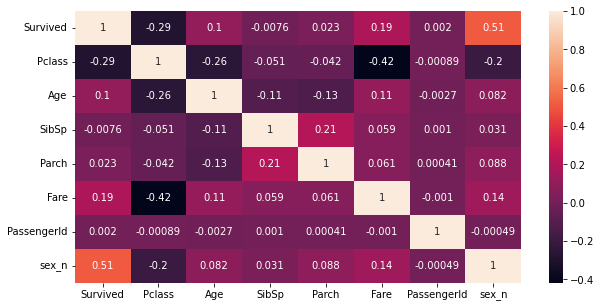

In [695]:
# самая сильная из имеющегося взаимосвязь
plt.figure(figsize=(10,5))
corr = data.corr()
sns.heatmap(corr, annot=True);

#### Взаимосвязь между полом и выживаемостью конечно имеется. По количественным показателям, мы видим, что основная масса выживших - это женщины, а основная масса погибших - мужчины. 
#### Т.к. конечно всегда первых спасают женщин и детей.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

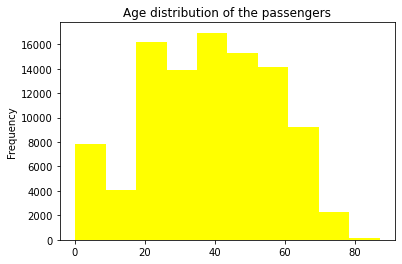

In [696]:
## Заполним недостающие значения средним значением
data['Age'].fillna(data['Age'].mean(), inplace=True)
#Посмотрим распредение пассажиров по возрасту.
data['Age'].plot(kind='hist',color='yellow',title='Age distribution of the passengers');

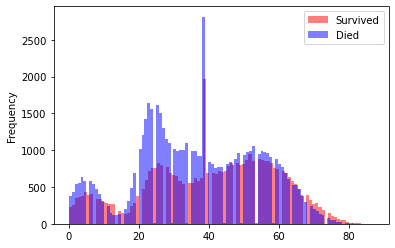

In [697]:
# Спасенные в разном возрасте
survived = data[data['Survived']==1]
died = data[data['Survived']==0]
survived['Age'].plot.hist(alpha=0.5,color='red',bins=100)
died['Age'].plot.hist(alpha=0.5,color='blue',bins=100)
plt.legend(['Survived','Died']);

In [698]:
survived['Age'].median()

42.0

In [699]:
# average - это mean
survived['Age'].mean()

40.484109043481375

In [700]:
died['Age'].median()

37.0

In [701]:
# average - это mean
died['Age'].mean()

36.76440663455104

#### Основная масса пассижиров в возрасте от 20 до 60. 
#### Распределение по возрасту отличается у выживших и умерших. 
#### Средний и медианный возраст больше у выживших, чем у умерших.
#### В основном погибали люди совсем маленького возраста и от 20 до ~35 лет.
#### Думаю это связано с тем, что богатыми как правило были люди в возрасте и их эвакуировали первыми.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

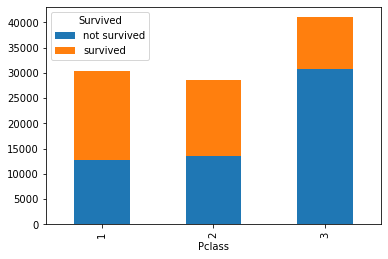

In [702]:
#Выжившие в разрезе класса кабины гистограммой
import warnings 
warnings.filterwarnings("ignore")

data_slice_Pclass_hist = data[['PassengerId', 'Pclass', 'Survived']]
data_slice_Pclass_hist['Survived'] = data_slice_Pclass_hist["Survived"].apply(lambda x: "survived" if x == 1 else "not survived")
data_slice_Pclass_hist.pivot_table('PassengerId', 'Pclass', 'Survived', 'count').plot(kind='bar', stacked=True);

In [703]:
PC['persent survived'] = PC['survived']*100/(PC['survived'] + PC['not survived'])
PC

Survived,not survived,survived,persent,persent survived
Pclass,,,,
1,12739,17576,57.977899,57.977899
2,13622,15057,52.501831,52.501831
3,30865,10141,24.730527,24.730527


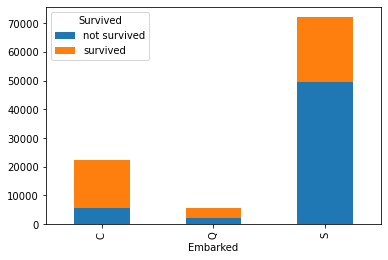

In [704]:
#Выжившие в разрезе порта посадки
data_slice_Embarked_hist = data[['PassengerId', 'Embarked', 'Survived']]
data_slice_Embarked_hist['Survived'] = data_slice_Embarked_hist["Survived"].apply(lambda x: "survived" if x == 1 else "not survived")
data_slice_Embarked_hist.pivot_table('PassengerId', 'Embarked', 'Survived', 'count').plot(kind='bar', stacked=True);

In [705]:
EM['persent survived'] = EM['survived']*100/(EM['survived'] + EM['not survived'])
EM

Survived,not survived,survived,persent survived
Embarked,,,
C,5518,16669,75.129580
Q,2186,3238,59.697640
S,49394,22745,31.529409


<Figure size 1440x720 with 0 Axes>

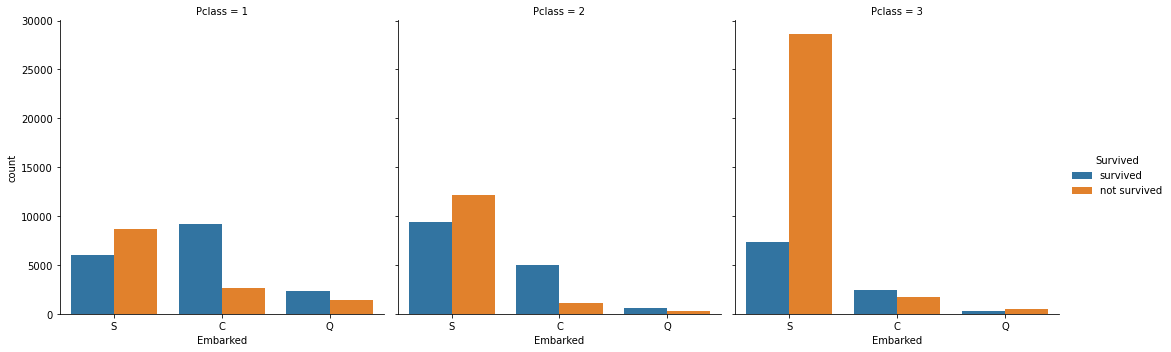

In [706]:
#Выживаемость от порта посадки по классам.
#Удалим записи с незаполненным Embarked
plt.figure(figsize=(20,10));
Embarked = data[['Survived', 'Embarked', 'Pclass']]
Embarked = Embarked.dropna()
Embarked['Survived'] = Embarked['Survived'].map({1: 'survived', 0: 'not survived'});
sns.catplot(x ='Embarked', hue ='Survived', kind ='count', col ='Pclass', data = Embarked);

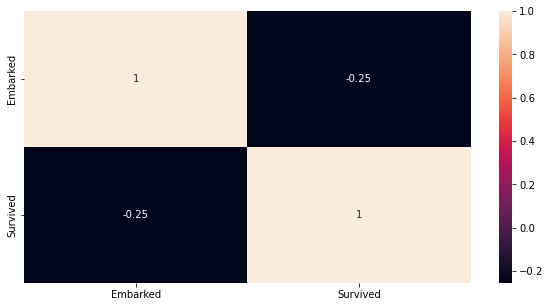

In [710]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')
plt.figure(figsize=(10,5))
data['Embarked'] = Embarked['Embarked'].map({'C': 1, 'S': 2, 'Q': 3});
corr = data[['Embarked','Survived']].corr()
sns.heatmap(corr, annot=True);

#### Самый безопасный класс это конечно же 1, т.к. процент выживания в нём приблизительно 58%. Но не сильно меньше во 2 классе, там 52,5%. Порт "С" можно назвать самым безопасным, т.к. процент выживших, севших там на борт, составляет 75%. Но по матрице корреляции не такая уж зависимость выживаемости от Порта, но и не нулевая.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [608]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')
n = data.shape[0]
isnull = data.isnull().sum().to_frame()
isnull*100/n

,0
Survived,0.000
Pclass,0.000
Name,0.000
Sex,0.000
Age,3.292
SibSp,0.000
Parch,0.000
Ticket,4.623
Fare,0.134
Cabin,67.866


Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

#### Получили самый большой процент пропуска в Cabin = 67.866%
#### Отсутствующие значения можно удалять перед исследованием фичи, а можно заполнять средним или медианным значением. Например Age лучше заменить средним значением, чем вовсе стереть, т.к. процент отсутствующих значений всего 3%, а значит вероятнее всего они будут похожи на большинство и большого значения не сыграют в общей массе. Fare (тариф) тоже можно заменить средним, но конечно лучше средним для своего класса. А вот Cabin слишком мало значений для каких-то замен, поэтому я бы при исследовании этого параметра просто удалила нулевые. И для Билета тоже бы удалила нулевые при исследовании связи с билетом. Для дополнения Embarked можно выбрать самый часто встречаемый вариант в датасете.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [1390]:
data_train = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

data_train['Age'].fillna(data_train['Age'].mean(), inplace = True)
data_train['Fare'].fillna(data_train['Fare'].mean(), inplace = True)

data_train.drop(columns=["Name"], inplace = True)
data_train['Cabin'] = data_train.Cabin.str[0] 
data_train.drop(columns=["Ticket"], inplace = True)

data_train.dropna(inplace = True)

y = data_train.Survived.to_frame()

train_numerical_features = list(data_train.select_dtypes(include=['int64', 'float64', 'int32']).columns)
ss_scaler = StandardScaler()
train_ss = pd.DataFrame(data = data_train)
train_ss[train_numerical_features] = ss_scaler.fit_transform(train_ss[train_numerical_features])

# get_dummies - преобразование категориальной переменной в фиктивные/индикаторные переменные.
encode_col_list = list(data_train.select_dtypes(include=['object']).columns)
for i in encode_col_list:
    train_ss = pd.concat([train_ss, pd.get_dummies(train_ss[i], prefix=i)], axis=1)
    train_ss.drop(i, axis = 1, inplace=True)

X = train_ss
X = X.drop(columns=["Survived"])

In [1391]:
SEED = 42
np.random.seed(SEED)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = SEED)

In [1392]:
## KNN
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier()

k_range = list(range(1, 40))
param_grid = dict(n_neighbors=k_range)

grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=False, verbose=1)
grid_search_knn = grid.fit(X_train, y_train)

Fitting 10 folds for each of 39 candidates, totalling 390 fits


In [1393]:
print(grid_search_knn.best_params_)

{'n_neighbors': 33}


In [1394]:
accuracy = grid_search_knn.best_score_ * 100
print("Accuracy для training лучший : {:.2f}%".format(accuracy) )

Accuracy для training лучший : 75.51%


In [1395]:
knn = KNeighborsClassifier(n_neighbors = grid_search_knn.best_params_['n_neighbors'])
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
test_accuracy=accuracy_score(y_test, y_pred)*100

print("Accuracy для testing фактический : {:.2f}%".format(test_accuracy) )

Accuracy для testing фактический : 75.13%


In [1396]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.70      0.65      0.68      3158
           1       0.78      0.81      0.80      4833

    accuracy                           0.75      7991
   macro avg       0.74      0.73      0.74      7991
weighted avg       0.75      0.75      0.75      7991



In [1397]:
## LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

LG = LogisticRegression()

parameters = {
            'penalty':['l1', 'l2'],
            'C':[1,5,10,30,80],
            'max_iter':[100, 120, 150],
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag'],
        }

grid = GridSearchCV(LG, parameters, cv=10, verbose=1)
grid_search_LG = grid.fit(X_train, y_train)

Fitting 10 folds for each of 120 candidates, totalling 1200 fits


In [1398]:
print(grid_search_LG.best_params_)

{'C': 5, 'max_iter': 150, 'penalty': 'l1', 'solver': 'liblinear'}


In [1399]:
accuracy = grid_search_LG.best_score_ * 100
print("Accuracy для training лучший : {:.2f}%".format(accuracy) )

Accuracy для training лучший : 75.47%


In [1400]:
LG = LogisticRegression(C=grid_search_LG.best_params_['C'], max_iter=grid_search_LG.best_params_['max_iter'], penalty=grid_search_LG.best_params_['penalty'], solver=grid_search_LG.best_params_['solver'])
LG.fit(X_train, y_train)
y_pred = LG.predict(X_test)
test_accuracy=accuracy_score(y_test, y_pred)*100

print("Accuracy для testing фактический : {:.2f}%".format(test_accuracy) )

Accuracy для testing фактический : 75.31%


In [1401]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.70      0.66      0.68      3158
           1       0.79      0.81      0.80      4833

    accuracy                           0.75      7991
   macro avg       0.74      0.74      0.74      7991
weighted avg       0.75      0.75      0.75      7991



**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [1402]:
## Чтобы улучшить Accuracy я возвращалась наверх и там обрабатывала ('Cabin' например 1 букву беру), скалировала, 
# чтобы не плодить кучу вариантов, а сразу оставить получше.

In [1407]:
data_test = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')

data_test['Age'].fillna(data_test['Age'].mean(), inplace = True)
data_test['Fare'].fillna(data_test['Fare'].mean(), inplace = True)

data_test.drop(columns=["Name"], inplace = True)
data_test['Cabin'] = data_test.Cabin.str[0] 
data_test.drop(columns=["Ticket"], inplace = True)

test_numerical_features = list(data_test.select_dtypes(include=['int64', 'float64', 'int32']).columns)
ss_scaler = StandardScaler()
test_ss = pd.DataFrame(data = data_test)
test_ss[test_numerical_features] = ss_scaler.fit_transform(test_ss[test_numerical_features])

encode_col_list = list(data_test.select_dtypes(include=['object']).columns)
for i in encode_col_list:
    test_ss = pd.concat([test_ss, pd.get_dummies(test_ss[i], prefix=i)], axis=1)
    test_ss.drop(i, axis = 1, inplace=True)

test_ss.isnull().sum()   

Pclass        0
Age           0
SibSp         0
Parch         0
Fare          0
Sex_female    0
Sex_male      0
Cabin_A       0
Cabin_B       0
Cabin_C       0
Cabin_D       0
Cabin_E       0
Cabin_F       0
Cabin_G       0
Cabin_T       0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64

In [1408]:
y_pred_LG = LG.predict(test_ss)

In [1409]:
data_test_LG = data_test.copy(deep=True)
data_test_LG.insert((data_test_LG.shape[1]),'Survived', y_pred_LG)
data_test_LG['Survived'].to_csv(os.path.join(PATH, 'titanic', 'LogisticRegression_SS_2.csv'))

In [1410]:
y_pred_KNN = knn.predict(test_ss)

In [1411]:
data_test_KNN = data_test.copy(deep=True)
data_test_KNN.insert((data_test_KNN.shape[1]),'Survived', y_pred_KNN)
data_test_KNN['Survived'].to_csv(os.path.join(PATH, 'titanic', 'KNN_SS_2.csv'))

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [1426]:
# Картинка с загруженными значениями в директории рядом.
# Странно, что когда я удаляла Cabin, то здесь получала 73%, а на kaggle 75%. 
# А когда обработала Cabin оставив 1 букву, стало здесь 75%, а на kaggle 74%. Неожиданно.
# К сожалению не знаю как до 79% дотянуть. 
# Ниже отчаянный шаг по просто убиранию колонок, чтоб не вносили "шума", и стало лучше неожиданно на kaggle 77,9%.

In [1427]:
data_train = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

data_train['Age'].fillna(data_train['Age'].mean(), inplace = True)

data_train.drop(columns=["Name"], inplace = True)
data_train.drop(columns=["Cabin"], inplace = True)
data_train.drop(columns=["Ticket"], inplace = True)
data_train.drop(columns=["SibSp"], inplace = True)
data_train.drop(columns=["Parch"], inplace = True)
data_train.drop(columns=["Fare"], inplace = True)

data_train.dropna(inplace = True)

y = data_train.Survived.to_frame()

train_numerical_features = list(data_train.select_dtypes(include=['int64', 'float64', 'int32']).columns)
ss_scaler = StandardScaler()
train_ss = pd.DataFrame(data = data_train)
train_ss[train_numerical_features] = ss_scaler.fit_transform(train_ss[train_numerical_features])

# get_dummies - преобразование категориальной переменной в фиктивные/индикаторные переменные.
encode_col_list = list(data_train.select_dtypes(include=['object']).columns)
for i in encode_col_list:
    train_ss = pd.concat([train_ss, pd.get_dummies(train_ss[i], prefix=i)], axis=1)
    train_ss.drop(i, axis = 1, inplace=True)

X = train_ss
X = X.drop(columns=["Survived"])

In [1428]:
SEED = 42
np.random.seed(SEED)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = SEED)

In [1429]:
## KNN
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier()

k_range = list(range(1, 40))
param_grid = dict(n_neighbors=k_range)

grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=False, verbose=1)
grid_search_knn = grid.fit(X_train, y_train)

knn = KNeighborsClassifier(n_neighbors = grid_search_knn.best_params_['n_neighbors'])
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
test_accuracy=accuracy_score(y_test, y_pred)*100

print("Accuracy для testing фактический : {:.2f}%".format(test_accuracy) )

Fitting 10 folds for each of 39 candidates, totalling 390 fits
Accuracy для testing фактический : 76.35%


In [1430]:
data_test = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')

data_test['Age'].fillna(data_test['Age'].mean(), inplace = True)

data_test.drop(columns=["Name"], inplace = True)
data_test.drop(columns=["Cabin"], inplace = True)
data_test.drop(columns=["Ticket"], inplace = True)
data_test.drop(columns=["SibSp"], inplace = True)
data_test.drop(columns=["Parch"], inplace = True)
data_test.drop(columns=["Fare"], inplace = True)

test_numerical_features = list(data_test.select_dtypes(include=['int64', 'float64', 'int32']).columns)
ss_scaler = StandardScaler()
test_ss = pd.DataFrame(data = data_test)
test_ss[test_numerical_features] = ss_scaler.fit_transform(test_ss[test_numerical_features])

encode_col_list = list(data_test.select_dtypes(include=['object']).columns)
for i in encode_col_list:
    test_ss = pd.concat([test_ss, pd.get_dummies(test_ss[i], prefix=i)], axis=1)
    test_ss.drop(i, axis = 1, inplace=True)

In [1431]:
y_pred_KNN = knn.predict(test_ss)

data_test_KNN = data_test.copy(deep=True)
data_test_KNN.insert((data_test_KNN.shape[1]),'Survived', y_pred_KNN)
data_test_KNN['Survived'].to_csv(os.path.join(PATH, 'titanic', 'KNN_SS_3.csv'))

In [895]:
# Приблизительные подсчёты по оценке:
#1. 2 + 0.5 + 0.5 + 0.5 + 0.5
#2. 0.5 + 0.5 (get_pairwise_distances и get_class_weights)
#3. 0.5 + 0.5 + 1 + 0.5 + 1.5 + 0.5(Kagle)

In [ ]:
# Итого: 4 + 1 + 4.5 = 9.5